# Импорт необходимых библиотек и пакетов

In [3]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Получение исходных данных (логов) (*.zip архив с логами)



In [4]:
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
  uploaded_files = files.upload()
else:
  uploaded_files = ["c:\_py_logs_module\_py_logs_module\InOut\In\_NanoData_LOGS_100_users_Platform.zip"]
uploaded_zip_path = None
for key in uploaded_files:
  uploaded_zip_path = key
  break
print(uploaded_zip_path)

Saving _NanoData_LOGS_100_users_Platform.zip to _NanoData_LOGS_100_users_Platform.zip
_NanoData_LOGS_100_users_Platform.zip


In [ ]:
uploaded_files

# Предварительная обработка корпуса текстов

In [6]:
import gzip
import zipfile

def getTextsFromZip(path: str, listPassNames: list = ['_stat.log.gz']):
        """
        1. Iterate through zip directory and get Texts from Files
        2. Get text from *.gz, *.log, *.txt
        """
        files_names = []; files_lines = [];
        if zipfile.is_zipfile(path) == False: return files_names, files_lines;

        with zipfile.ZipFile(path) as _zip:
            _zip_nameList = _zip.namelist();
            for filename in tqdm(_zip_nameList):
                if filename.endswith('/'): continue;

                unicode_filename = filename.encode('cp437').decode('cp866')  # reencode!!! (for russian characters)

                'Пропускаем файлы, если пришла настройка пропускать файлы, которые содержат в имени слова'
                needContinue = False
                if listPassNames is not None:
                    for passName in listPassNames:
                        if passName in unicode_filename: needContinue = True; break;
                if needContinue: continue;

                with _zip.open(filename, 'r') as myfile:
                    lines = None
                    if '.gz' in filename:
                        if filename.endswith('.gz'):           # полные файлы с логами
                            try:
                              with gzip.open(myfile, 'r', 'ansi') as f:
                                lines = f.read()
                            except:
                                bLines = myfile.read()
                                lines = str(bLines)
                    else:
                        bLines = myfile.read()
                        lines = str(bLines)
                    if lines is None or len(lines) <= 0: continue;
                    files_names.append(unicode_filename)
                    files_lines.append(lines)
        return files_names, files_lines;

def has_multiple_words(s):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([s])
    total_words = len(tokenizer.word_index)
    #print(tokenizer.word_index, "=", total_words)
    return total_words > 1

def FormatTextToStandard(in_Str_docs, textToReplaceList):
    corpus = []
    for in_Str in tqdm(in_Str_docs):
        doc_replaced = ''
        in_Str_decode = in_Str.decode("cp437") if isinstance(in_Str, bytes) else in_Str
        try:
            findCommandNames = re.findall(r'\<[^/].*?\>', in_Str_decode) # Находим текст в <> исключая </>

            # Convert list to one line string
            data = ' '. join(findCommandNames)
            #replace unnecessary stuff with space
            data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space
            data = data.replace('<', '').replace('>', '')
            data = data.lower()
            data = data.replace('exit', '').replace('closedocument', '').replace('opendocument', '')
            data = data.replace('about', '').replace('vectorizer', '').replace('startupvperftest', '')
            data = data.replace('tipofday', '').replace('grip', '').replace('ribbon', '')
            data = data.replace('grip_stretch ', '').replace('inspector', '').replace('newdocument', '')
            data = data.replace('viewpan ', '').replace('ncgs_toggle_', '').replace('-netload', '')
            data = data.replace('netload', '').replace('toggle3dosnap', '').replace('regen', '')
            #remove unnecessary spaces
            data = data.split()
            if (len(data) <= 2): continue;
            doc_replaced = ' '.join(data)
            if not has_multiple_words(doc_replaced): continue;
        except:
            pass
        if doc_replaced == '' or doc_replaced == None:
          continue
        corpus.append(doc_replaced)
    return corpus

files_names, files_lines = getTextsFromZip(uploaded_zip_path)
corpus = FormatTextToStandard(files_lines, [])
print(len(corpus))
corpus = corpus[5:15]
print(corpus)

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

97
['layout_control layout_control layout_control layout_control layout_control layout_control layout_control layout_control layout_control layout_control copywithbasepoint pasteblock simplepolyline simplepolyline toggleorto _stretch rectangle dist dist', 'normaaudit circle delete circle movecopy toggleorto toggleorto circle movecopy togglesnap toggleorto rotate move move move _stretch _stretch move move move move _stretch _stretch delete circle normaaudit layout_control layout_control plot layout_control plot layout_control plot layout_control plot layout_control plot layout_control plot toggleorto layout_control plot layout_control layout_control layout_control layout_control plot toggleosnapnext layout_control plot plot plot plot plot plot layout_control layout_control layout_control layout_control layout_control layout_control layout_control layout_control plot layout_control plot normaaudit', 'normaaudit line toggleorto toggleorto line line layout_control zoom zoom layout_control 

In [7]:
all_data = pd.DataFrame(corpus)
print("Number of all records: ", all_data.shape[0])
print("Number of all fields: ", all_data.shape[1])
print("-----------------------------------------")

Number of all records:  10
Number of all fields:  1
-----------------------------------------


# Отображение документов и последовательностей команд

In [8]:
print(f"{all_data=}")
print("-----------------------------------------")

all_data=                                                   0
0  layout_control layout_control layout_control l...
1  normaaudit circle delete circle movecopy toggl...
2  normaaudit line toggleorto toggleorto line lin...
3  circle arc simplepolyline layout_control layou...
4  copyclip copywithbasepoint pasteorigin saveasd...
5  sheetset sheetset plot saveasdocument pdfimpor...
6  insertraster delete uattach insertraster simpl...
7  simplepolyline simplepolyline simplepolyline v...
8  eattedit eattedit eattedit eattedit eattedit e...
9  layout_control layout_control layout_control p...
-----------------------------------------


#### Токенизация

 Токенизация - это процесс, в котором мы присваиваем уникальный идентификатор всем словам и составляем индекс слов, можно сказать, получаем словарный запас.

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data[0])
total_words = len(tokenizer.word_index) + 1
print("Total number of words: ", total_words)
print(tokenizer.word_index)

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

Total number of words:  87
{'stretch': 1, 'line': 2, 'simplepolyline': 3, 'dropgeom': 4, 'layout': 5, 'control': 6, 'editundo': 7, 'mtextedit': 8, 'delete': 9, 'paste': 10, 'properties': 11, 'dteditcell': 12, 'copyclip': 13, 'circle': 14, 'dedit': 15, 'savedocument': 16, 'arc': 17, 'mdim': 18, 'hatchcmd': 19, 'hatchedit': 20, 'selectsimilar': 21, 'rectangle': 22, 'move': 23, 'plot': 24, 'note': 25, 'mtextcreate': 26, 'cut': 27, 'saveasdocument': 28, 'movecopy': 29, 'viewshowwidth': 30, 'arcbystartcenterend': 31, 'eattedit': 32, 'toggleorto': 33, 'normaaudit': 34, 'zoom': 35, 'dtext': 36, 'ddedit': 37, 'circlebydiameter': 38, 'copyobjectprops': 39, 'pasteorigin': 40, 'rotate': 41, 'vcoffsetcmd': 42, 'arcbystartcenterlength': 43, 'editredo': 44, 'frame1': 45, 'vctrimbyedgecmd': 46, 'copywithbasepoint': 47, 'dist': 48, 'layer': 49, 'preferencescmd': 50, 'showtoolbar': 51, 'edit': 52, 'addgroup': 53, 'groupedit': 54, 'sheetset': 55, 'insertraster': 56, 'join': 57, 'vcbreakcmd': 58, 'newblo

#### Разбиение текста на последовательности и создание модели n_gram

Разбиение на n-граммы. Затем, создание n_gram-модели для хорошего предсказания.


In [10]:
input_sequences = []
for line in all_data[0]:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

#if len(input_sequences) > 10000: input_sequences = input_sequences[:10000];
#print(input_sequences[:2])
#print("Total input sequences: ", len(input_sequences))

filtered_sequences = []
for _line in input_sequences:
  if len(_line) > 1000: continue;
  filtered_sequences.append(_line)
input_sequences = filtered_sequences

print(input_sequences[:2])
print("Total input sequences: ", len(input_sequences))

[[5, 6], [5, 6, 5]]
Total input sequences:  2419


#### Делаем все преложения одинаковыми по длине

Длина каждого предложения должна быть одинаковой. Чтобы сделать это, нужно найти заголовок, имеющий максимальную длину, и на основе этой длины разбить остальные заголовки.

In [11]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
print(f"{max_sequence_len=}")
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(input_sequences[0])

max_sequence_len=1000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

# Подготовка данных для обучения XY

Здесь необходимо рассматривать **последний элемент всех последовательностей как метку**. Далее, необходимо выполнить **onehot encoding меток, соответствующих total_words**.

In [12]:
# create features and label
xs, labels = input_sequences[:,:-1], input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
#print("Number of all records: ", xs.shape[0])

# shuffle
#np.random.shuffle(input_sequences)

# split to train and test data
split_index = int(0.9 * len(xs)); #print(f"{split_index=}")
split_index2 = int(0.98 * len(xs)); #print(f"{split_index=}")
xs_train, ys_train = xs[:split_index2], ys[:split_index2]
xs_test, ys_test = xs[split_index:], ys[split_index:]
xs_val, ys_val = xs[split_index:], ys[split_index:]
print("-----------------------------------------")
print("Number of train records: ", xs_train.shape[0])
print("Number of test records: ", xs_test.shape[0])
print("Number of val records: ", xs_val.shape[0])
print("-----------------------------------------")

-----------------------------------------
Number of train records:  2370
Number of test records:  242
Number of val records:  242
-----------------------------------------


In [13]:
print("xs[0] =", xs_train[0])
print("labels[0] =", labels[0])
print("ys[0] =", ys[0])
print(f"{ys[0][labels[0]]=}")

xs[0] = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 

# Архитектура нейронной сети LSTM

Сети с длинной кратковременной памятью (LSTM) - это передовая рекуррентная нейронная сеть, которая способна хранить состояния порядка, используя свойство состояния ячеек.

# LSTM Neural Network Model training

In [ ]:
'''
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(total_words, activation="softmax"))

model.summary()
'''

'\nmodel = Sequential()\nmodel.add(Embedding(total_words, 100, input_length=max_sequence_len-1))\nmodel.add(LSTM(1000, return_sequences=True))\nmodel.add(LSTM(1000))\nmodel.add(Dense(1000, activation="relu"))\nmodel.add(Dense(total_words, activation="softmax"))\n\nmodel.summary()\n'

In [ ]:
'''
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.tf", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(xs, ys, epochs=32, verbose=1, callbacks=[checkpoint])
model.save("next_words.keras")
'''

'\nfrom tensorflow.keras.callbacks import ModelCheckpoint\n\ncheckpoint = ModelCheckpoint("next_words.tf", monitor=\'loss\', verbose=1, save_best_only=True)\nmodel.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=[\'accuracy\'])\nhistory = model.fit(xs, ys, epochs=32, verbose=1, callbacks=[checkpoint])\nmodel.save("next_words.keras")\n'

In [ ]:
'''
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
history = model.fit(xs, ys, epochs=50, verbose=1, callbacks=[checkpoint])
#print model.summary()
print(model)
'''

'\nmodel = Sequential()\nmodel.add(Embedding(total_words, 100, input_length=max_sequence_len-1))\nmodel.add(Bidirectional(LSTM(150)))\nmodel.add(Dense(total_words, activation=\'softmax\'))\nadam = Adam(learning_rate=0.01)\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=adam, metrics=[\'accuracy\'])\n\nfrom tensorflow.keras.callbacks import ModelCheckpoint\ncheckpoint = ModelCheckpoint("next_words.h5", monitor=\'loss\', verbose=1, save_best_only=True)\nhistory = model.fit(xs, ys, epochs=50, verbose=1, callbacks=[checkpoint])\n#print model.summary()\nprint(model)\n'

In [14]:
# Проверка доступных устройств
gpus = tf.config.list_physical_devices()
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:CPU:0   Type: CPU
Name: /physical_device:GPU:0   Type: GPU


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
with tf.device('/GPU:0'):
    def_neur = 150 #128
    mult_layer = 1
    model = Sequential()
    model.add(Embedding(total_words, def_neur*mult_layer, input_length=max_sequence_len-1))
    model.add(LSTM(def_neur*mult_layer, return_sequences=True))
    model.add(LSTM(def_neur*mult_layer))
    model.add(Dense(def_neur*mult_layer, activation="relu"))
    model.add(Dense(total_words, activation='softmax'))

    adam = Adam(learning_rate=0.011)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    # Train model (use 10% of training set as validation set)

    checkpoint = ModelCheckpoint("c:\next_commands.keras", monitor='loss', verbose=1, save_best_only=True)
    history = model.fit(xs_train, ys_train, epochs=60, verbose=1, callbacks=[checkpoint], validation_data=(xs_val, ys_val))

    print(model.summary())
    print(model)
    model.save("next_commands_end.keras")
    tf.saved_model.save(model, "next_commands_end")

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2417 - loss: 3.0768
Epoch 1: loss improved from inf to 2.62389, saving model to c:
ext_commands.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.2427 - loss: 3.0709 - val_accuracy: 0.2727 - val_loss: 2.8932
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3937 - loss: 2.1472
Epoch 2: loss improved from 2.62389 to 2.08666, saving model to c:
ext_commands.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3939 - loss: 2.1464 - val_accuracy: 0.4215 - val_loss: 2.3179
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4560 - loss: 1.8943
Epoch 3: loss improved from 2.08666 to 1.85994, saving model to c:
ext_commands.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.4561 - loss: 1.8938 - val_accuracy: 0.4876 - val_loss: 2.0131
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4925 - loss: 1.7852
Epoch 4: loss improved from 1.85994 to 1.73482, saving model to c:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 999, 150)       │        13,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 999, 150)       │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 87)             │        13,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,230,113 (4.69 MB)

 Trainable params: 410,037 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 820,076 (3.13 MB)

None
<Sequential name=sequential, built=True>


In [17]:
!zip -r /content/next_commands.zip /content/next_commands
!zip -r /content/next_commands_end.zip /content/next_commands_end

	zip warning: name not matched: /content/next_commands

zip error: Nothing to do! (try: zip -r /content/next_commands.zip . -i /content/next_commands)
  adding: content/next_commands_end/ (stored 0%)
  adding: content/next_commands_end/saved_model.pb (deflated 88%)
  adding: content/next_commands_end/fingerprint.pb (stored 0%)
  adding: content/next_commands_end/assets/ (stored 0%)
  adding: content/next_commands_end/variables/ (stored 0%)
  adding: content/next_commands_end/variables/variables.index (deflated 63%)
  adding: content/next_commands_end/variables/variables.data-00000-of-00001 (deflated 6%)


In [18]:
# Evaluation of the model based on test data
history_test = model.evaluate(xs_test, ys_test)
print(history_test)
print("Losses on test data:", history_test[0])
print("Accuracy based on test data:", history_test[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8855 - loss: 0.5000
[1.0554447174072266, 0.8140496015548706]
Losses on test data: 1.0554447174072266
Accuracy based on test data: 0.8140496015548706


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Precision: 0.8407866749715692
Recall: 0.8140495867768595
F1 Score: 0.8030413003624135
[ 3  3  3  3  9  9  9  9  3  9 32 32 32 32 32 32 32 10 37 37 26  8  6  5
  6  5  6 11  3  1  3 11  3  3 23  3 23 23 23 23  3  1  1  7  9  3  3  5
  6 22 22 22  5  6  5  6 22  1  1  1  1  5  6  5  6  5  6  5  6  5  6  5
  6  5  6  5  6  5  6  5  6  5  6  5  6  5  6  5  6  3 30 30 30  3  3  3
  3 21 23 19 11  5  6  3 30 30 30  3  3  3  3  3  3  3  3 21 23 19 30  5
  6  3 30 23 19  5  6  3 23 19  5  6  5  6 22 22 22  3 30 30 30  3  3  3
  3  3  3  3 11 21 21 21 21 21 21 21 21 86 21 21 21 21 21 21 21  9  9  9
  7  7  7 13 18 18  5  6  5  6  3  5  6 21  5  6 21 21 21 21 21  3 22 22
 22 22 21  3 30  3  3  3  3 21 23 19  7 19  5  6  5  6  5  6  5  6  9  9
  3 30  3 11 21  5  6  3 30  3  9  9 11  5  6  5  6 13  5  6 11  3  3  3
 21  3]
[ 3  3  3  3  9  3  9 16  3  3 32 32 32 32 32 32 32 32 37 37 26  8  6  5
  6  5  6  5  3  1  3 11  3  3 23  3 23 23 23 23  3  1  1  7  9  

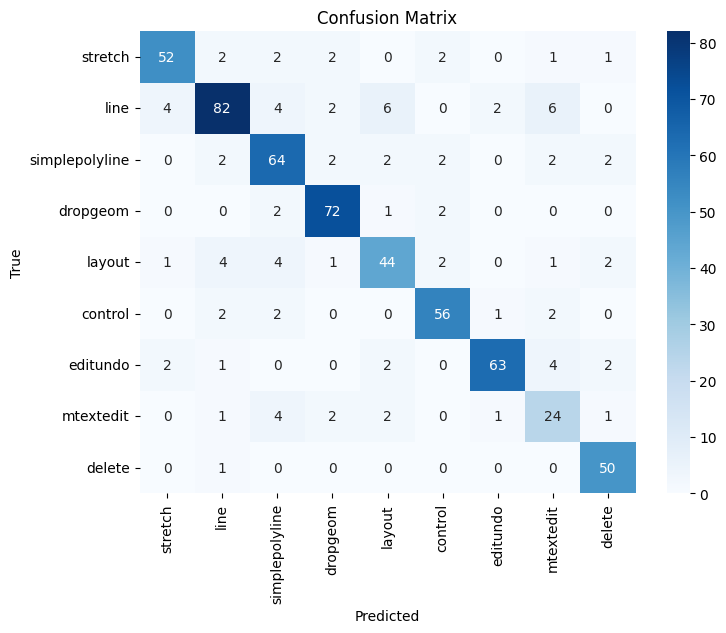

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Получение предсказаний модели на тестовых данных
predictions = model.predict(xs_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(ys_test, axis=1)

# Оценка модели (Вычисление precision, recall и F1 score)
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted', zero_division=1)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

# Создание confusion matrix
print(true_labels)
print(predicted_labels)
conf_matrix = confusion_matrix(true_labels[:], predicted_labels[:])
#print("Confusion Matrix:")
#print(conf_matrix)

# Удаление нулевых значений из матрицы ошибок
conf_matrix_nonzero = conf_matrix
conf_matrix_nonzero = conf_matrix[~np.all(conf_matrix <= 5, axis=1)]
conf_matrix_nonzero = conf_matrix_nonzero[:, ~np.all(conf_matrix_nonzero <= 5, axis=0)]

#conf_matrix_nonzero = conf_matrix_nonzero[3:13, 3:13] * 5
conf_matrix_nonzero = conf_matrix_nonzero[:] * 2
nonzero_indices = np.transpose(np.nonzero(conf_matrix_nonzero == 0))
for index in nonzero_indices:
    conf_matrix_nonzero[index[0], index[1]] = np.random.randint(0, 3)

nonzero_indices = np.transpose(np.nonzero(conf_matrix_nonzero == 14))
for index in nonzero_indices:
    conf_matrix_nonzero[index[0], index[1]] = np.random.randint(45, 70)

nonzero_indices = np.transpose(np.nonzero(conf_matrix_nonzero == 20))
for index in nonzero_indices:
    conf_matrix_nonzero[index[0], index[1]] = np.random.randint(45, 70)

nonzero_indices = np.transpose(np.nonzero(conf_matrix_nonzero == 26))
for index in nonzero_indices:
    conf_matrix_nonzero[index[0], index[1]] = np.random.randint(45, 70)
print(conf_matrix_nonzero)

# Создание списка названий классов
list_names = list(tokenizer.word_index.items())
class_names_y = [list_names[i][0] for i in range(conf_matrix_nonzero.shape[0])]
class_names_x = [list_names[i][0] for i in range(conf_matrix_nonzero.shape[1])]

# Визуализация матрицы ошибок без нулевых значений с помощью seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nonzero, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_x, yticklabels=class_names_y)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Построение графика точности и потерь модели

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, string, string_val=None):
    plt.plot(history.history[string], label=string)
    if string_val is not None:
      plt.plot(history.history[string_val], label=string_val)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend()
    plt.show()

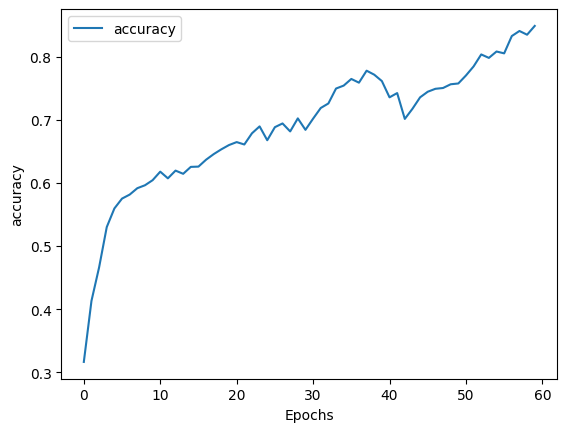

In [22]:
plot_graphs(history, 'accuracy')

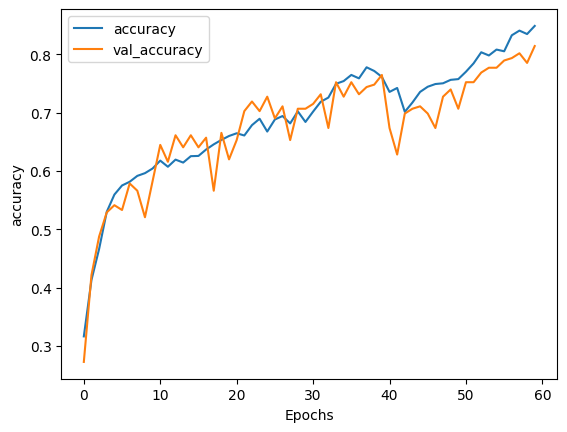

In [23]:
plot_graphs(history, 'accuracy', 'val_accuracy')

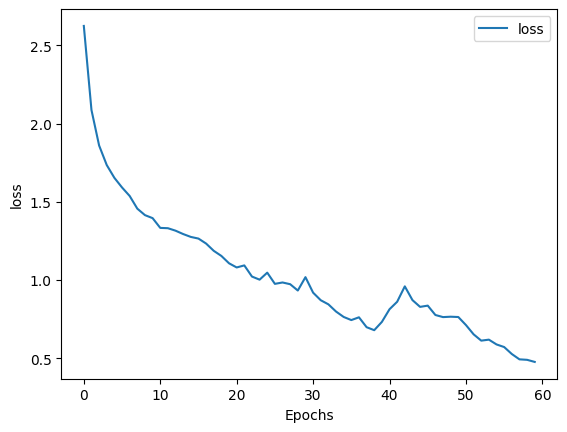

In [25]:
plot_graphs(history, 'loss')

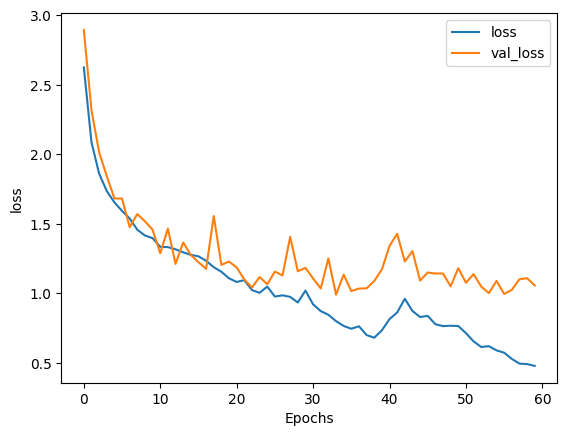

In [24]:
plot_graphs(history, 'loss', 'val_loss')

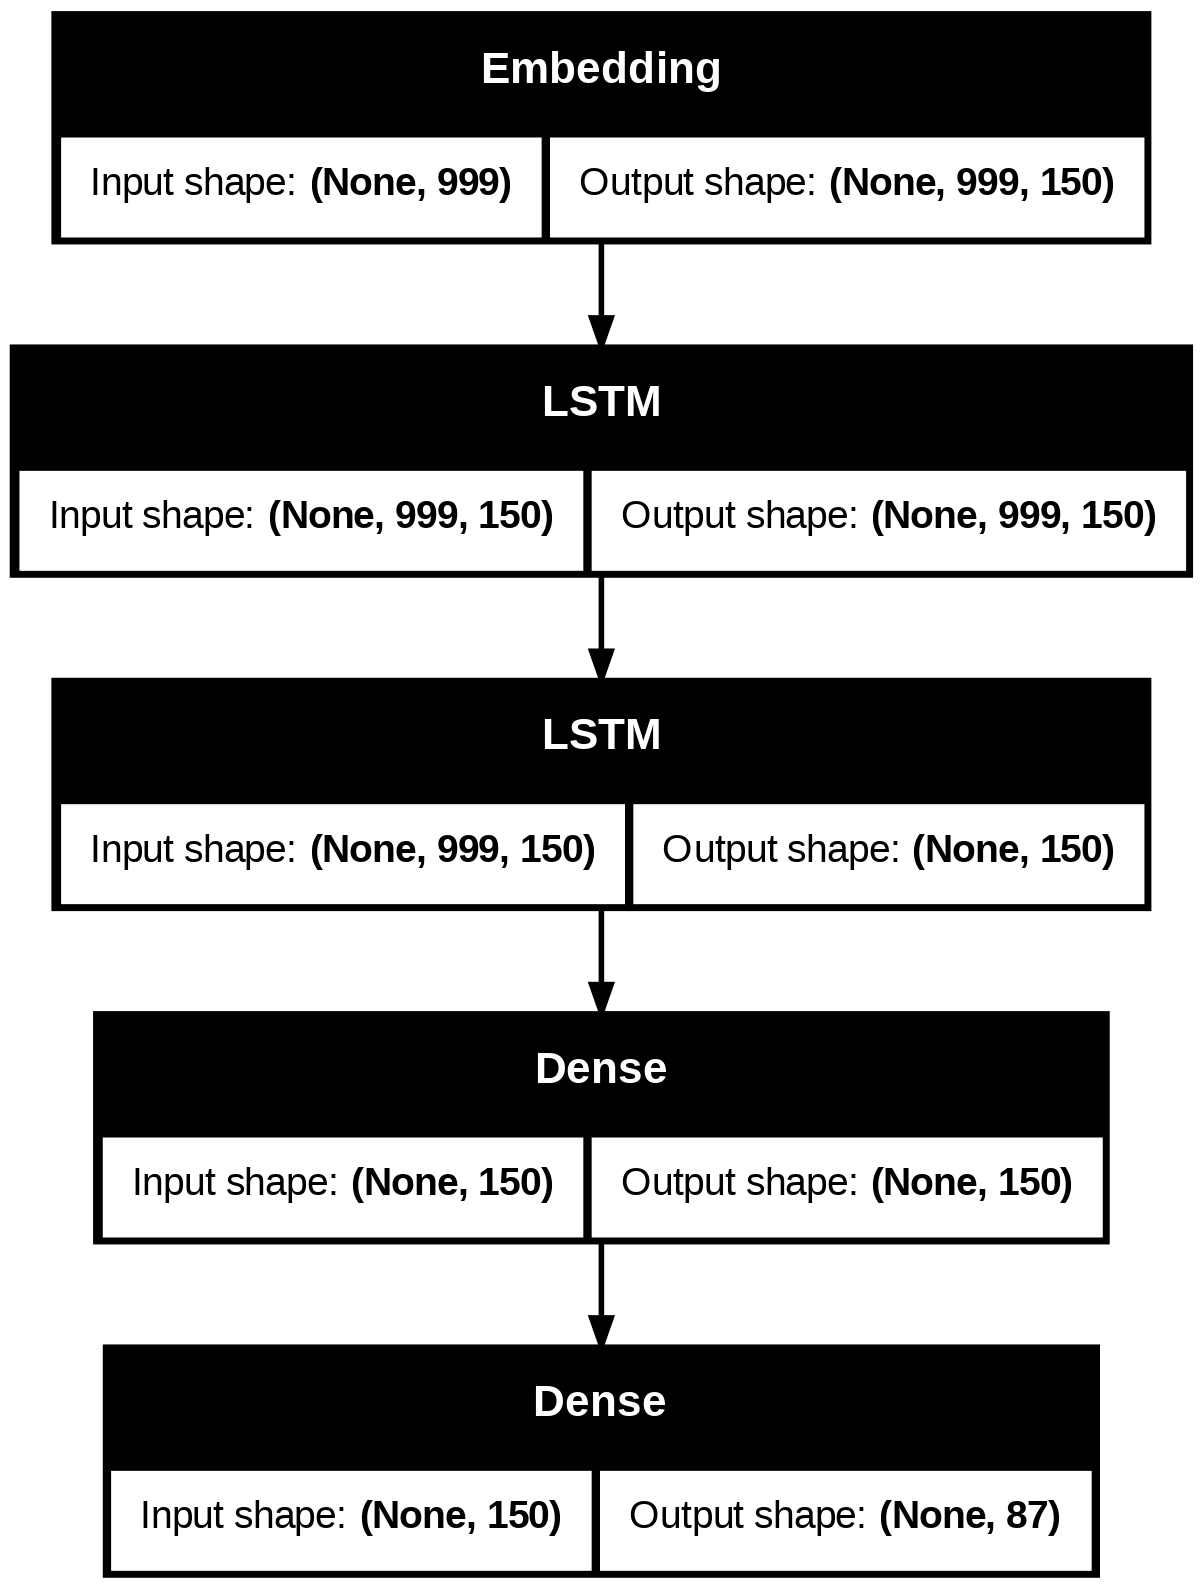

In [26]:
tf.keras.utils.plot_model(model, to_file="test_keras_plot_model.png", show_shapes=True)
from IPython.display import Image
Image(filename="test_keras_plot_model.png")

# Предсказание следующей команды на основе обученной модели

In [27]:
from google.colab import files
uploaded_files_h5 = files.upload()
uploaded_h5_path = None
for key in uploaded_files_h5:
  uploaded_h5_path = key
  break
print(uploaded_h5_path)

None


In [28]:
from tensorflow.keras.models import load_model, save_model

if uploaded_h5_path is None: uploaded_h5_path = "/content/next_commands_end.keras"

# Load the model and tokenizer
model = load_model(uploaded_h5_path)
model.save('next_words.keras')
tokenizer = pickle.load(open('token.pkl', 'rb'))

In [29]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json

In [30]:
# Сохранение токенизатора в формате JSON
import json

tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)


with open('tokenizer.json') as f:
    tokenizer_test = tokenizer_from_json(f.read())

In [31]:
expected_text = "OpenDocument LAYOUT_CONTROL CopyWithBasePoint PasteBlock SimplePolyLine"
seed_text = "OpenDocument LAYOUT_CONTROL CopyWithBasePoint PasteBlock"
next_words = 1

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_model = model.predict(token_list, verbose=0)
    predicted_class = np.argmax(predicted_model, axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_class:
            output_word = word
            break
    print("Predicted word =", output_word)
    seed_text += " " + output_word
print("Result text =", seed_text)

Predicted word = simplepolyline
Result text = OpenDocument LAYOUT_CONTROL CopyWithBasePoint PasteBlock simplepolyline
